Estudiante:

- Irving Mera
- Robinson Maqui

# Práctico MABWISER
¿
Adaptado de los tutoriales disponibles en: https://github.com/fidelity/mabwiser/tree/master/examples

## Reinforcement Learning

Un agente de RL busca tomar acciones que logren maximizar la ganancia acumulativa.

![RL setup](https://github.com/bamine/recsys-summer-school/raw/12e57cc4fd1cb26164d2beebf3ca29ebe2eab960/notebooks/images/rl-setup.png)


## Exploration vs. Exploitation

Se busca encontrar un balance entre la exploración (decidir tomar una acción para ganar conocimiento) y exploitación (decidir la acción que se calcula que tendrá la mejor ganancia).

![texto alternativo](https://miro.medium.com/max/1400/1*_5dltx4BcI8rRmCK2Sq_kw.png)

## Importar paquetes necesarios

In [4]:
!pip install mabwiser
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.preprocessing import StandardScaler

from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy
import numpy as np

import random
from mabwiser.simulator import Simulator
from scipy.spatial.distance import cdist

from mabwiser.linear import _Linear
from mabwiser.mab import _EpsilonGreedy
from mabwiser.utils import argmax, Arm, Num, create_rng, _BaseRNG

from typing import List

from time import time

## Problema con contexto:

Una plataforma de comercio virtual cuenta con 5 _ads_ y quiere determinar cuál de estos generará mayor recompensa para un usuario en específico. Para esto, se cuenta con la información histórica de las recompensas obtenidas por otros usuarios con distintos _ads_ junto con la información de la edad, la razón de clicks y si cada usuario es subscriptor o no.

In [5]:
# Brazos, en este caso representan los 5 ads que se tienen disponibles para mostrarle a los usuarios.
ads = [1, 2, 3, 4, 5]

# Se tiene la data histórica, estos pueden ser datos recopilados "off-policy", es decir, no necesariamente se recopilaron utilizando la política del
# agente que utilizaremos acá. En este caso, ad representa el brazo elegido, revenue la recompensa recolectada y age, click_rate y subscriber forman
# el contexto del usuario. Por ejemplo, el primer usuario tiene edad 22, un click_rate de 0.2 y es subscriptor, se le mostró el ad 1 y con esto se
# obtuvo una recompensa de 10.
train_df = pd.DataFrame({'ad': [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
                         'revenues': [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
                         'age': [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
                         'click_rate': [0.2, 0.6, 0.99, 0.68, 0.15, 0.23, 0.75, 0.17,
                                        0.33, 0.65, 0.56, 0.22, 0.19, 0.11, 0.83],
                         'subscriber': [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]}
                        )

# test_df representa el contexto de nuevos usuarios a los que se le desea entregar un ad.
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
# El revenue es la recompensa que se obtiene al entregarle un ad a estos usuarios. En un contexto real, esta recompensa sería entregada por el modelo
# después de haberle entregado el ad a los usuarios, pero para este tutorial la vamos a definir de antemano
test_df_revenue = pd.Series([7, 13])

# Escalar el contexto del entrenamiento y testeo. Se deben escalar las características del contexto para evitar que una característica tenga más peso
# solo por la escala de sus valores.
scaler = StandardScaler()
print(train_df[['age', 'click_rate', 'subscriber']].values)
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

[[22.    0.2   1.  ]
 [27.    0.6   0.  ]
 [39.    0.99  1.  ]
 [48.    0.68  0.  ]
 [21.    0.15  1.  ]
 [20.    0.23  0.  ]
 [19.    0.75  1.  ]
 [37.    0.17  1.  ]
 [52.    0.33  1.  ]
 [26.    0.65  0.  ]
 [18.    0.56  1.  ]
 [42.    0.22  1.  ]
 [55.    0.19  0.  ]
 [57.    0.11  1.  ]
 [38.    0.83  0.  ]]


Se utilizará un algoritmo UCB1 para tomar decisiones. El algoritmo UCB1 estima la recompensa y elige la opción que tenga el límite superior de la predicción más elevado.


In [6]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# Una recomendación no-paramétrica con contexto, requiere de una política de vecindad (Neighborhood Policy) para tomar decisiones basado en los
# usuarios más "cercanos" al usuario objetivo.

# Política de vecindad KNearest con k=5 y política de aprendizaje ucb1 con alpha=1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# El brazo aprende de las recompensas históricos.
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Se realiza la predicción.
prediction = knearest.predict(test)

# Esperanza de recompensa para cada ad (este paso no es necesario, pero sirve para visualizar la toma de desiciones).
expectations = knearest.predict_expectations(test)

# Resultado
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Se actualiza la política de manera online con los nuevos resultados obtenidos (recordar que la recompensa se definió de antemano)
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Se puede agregar un nuevo brazo cuando sea necesario
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


### Actividad 1:
Suponga que a ambos usuarios, se les presenta el nuevo _ad_, $6$, obteniendo un revenue de $40$ para el primero y $10$ para el segundo.

Es decir, utilice el método _partial\_fit_ dándole como decisions el brazo [6], rewards=[40] y contexts=test, e imprima el resultado knearest.predict_expectations(test). Observe la predicción del brazo $6$ para cada usuario y si hubo cambios en la recompensa predicha para el resto de los brazos.

**Solución:**

In [8]:
# Inicialización de MAB con políticas de vecindad y aprendizaje
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Entrenar con datos históricos definidos en el punto anterior
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predicción antes de la actualización con el nuevo ad
predictions = knearest.predict(test)
expectations = knearest.predict_expectations(test)

# Agregar el nuevo ad 6
knearest.add_arm(6)
#Se añade nueva decisión en base al ad 6
new_ad_decisions = [6, 6]
#Adición de ganancias
new_ad_rewards = [40, 10]
new_ad_contexts = test

# Actualización del modelo con datos del nuevo ad
knearest.partial_fit(decisions=new_ad_decisions, rewards=new_ad_rewards, contexts=new_ad_contexts)

# Predicción después de agregar el nuevo ad
updated_expectations = knearest.predict_expectations(test)

print("Predicciones iniciales sin ad6: ", expectations)
print("Predicciones actualizadas con ad6: ", updated_expectations)

Predicciones iniciales:  [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]
Predicciones actualizadas:  [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 12.242653222492628, 6: 42.24265322249263}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 0, 4: 0, 5: 7.242653222492627, 6: 12.242653222492628}]


**Comentarios:**

En base a la nueva adición del anuncio 6, ha sido actualizado con una recompensa bastante alta (42, tomando como ganancia original 40), lo que refleja claramente un valor esperado alto ya que resulta muy atractivo el anuncio 6 para un usuario similar en futuras decisiones.

Referente al segundo usuario, el incremento en la expectativa del anuncio 6 resulta un poco mayor (12, tomando como ganancia original 10), por lo que se indica que el modelo ha sido ajustado sus expectativas en base a la nueva información que toma en cuenta las decisiones pasadas y las recompensas relacionadas con otros anuncios que tienen un peso considerable en la decisión final.

## Problema sin contexto:

El sitio ahora quiere elegir entre dos posibles opciones de diseño para su página principal. Para esto tiene datos históricos de la recompensa aportado por cada diseño, pero no cuenta con ningún dato acerca de los usuarios.

In [9]:
# Brazos
options = [1, 2]
# Datos históricos (esta vez sin contexto del usuario), cada elemento representa una sesión de un usuario, ejemplo al primer usuario se le muestra el
# layout 1 y se obtiene un revenue 10.
layouts = [1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1]
revenues = [10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10]

En esta actividad, se utiliza la política Epsilon Greedy, la cual elige el brazo con una mayor esperanza de recompensa con probabilidad (1-epsilon).


In [10]:
###################################
# Epsilon Greedy Learning Policy
###################################

# Se utiliza la política Epsilon Greedy con epsilon=15%, lo que significa que un 85% de las veces elegirá el brazo con mayor esperanza de recompensa.
# modificando o eliminando el valor de seed se pueden obtener resultados distintos.
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=12345)

# Se ajusta el modelo con los datos históricos
greedy.fit(decisions=layouts, rewards=revenues)

# Se predice
prediction = greedy.predict()

# Se almacenan los valores esperados
expectations = greedy.predict_expectations()

print("Epsilon Greedy: ", prediction, " ", expectations)

# A medida que se generan nuevos resultados, se almacenan las recompensas y se pueden usar para actualizar el modelo.

additional_layouts = [1, 2, 1, 2]
additional_revenues = [25, 2, 19, 1]

greedy.partial_fit(additional_layouts, additional_revenues)

prediction = greedy.predict()
expectations = greedy.predict_expectations()

print("Epsilon Greedy: ", prediction, " ", expectations)
# Observamos que, al actualizar el modelo con recompensas altas para la opción 1 y bajas para la opción 2, la opción 1 pasa a ser la opción con mayor
# valor esperado

Epsilon Greedy:  2   {1: 10.875, 2: 14.714285714285714}
Epsilon Greedy:  1   {1: 13.1, 2: 11.777777777777779}


### Actividad 2:
Suponga ahora que se muestran ambos anuncios y en ambos, se obtiene una recompensa de $20$, es decir, genere un vector de layouts $[1,2]$ y recompensas $[20,20]$ y con esto invoque a la función partial\_fit e imprima lo entregado por _predict\_expectations()_. Qué valor esperado aumentó más? Por qué?

**Solución:**

In [11]:
# Inicialización del modelo Epsilon Greedy
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=12345)  # Semilla para reproducibilidad

# Ajuste del modelo con los datos históricos
greedy.fit(decisions=layouts, rewards=revenues)

# Predicción inicial y expectativas de recompensa
initial_prediction = greedy.predict()
initial_expectations = greedy.predict_expectations()

print("Epsilon Greedy antes de la actualización: ", initial_prediction, " ", initial_expectations)

# Actualización del modelo con nuevos datos donde ambas opciones obtienen la misma recompensa
new_layouts = [1, 2]  # Nuevas decisiones
new_revenues = [20, 20]  # Nuevas recompensas

# Actualización del modelo con los nuevos resultados
greedy.partial_fit(new_layouts, new_revenues)

# Predicción y expectativas después de la actualización
updated_prediction = greedy.predict()
updated_expectations = greedy.predict_expectations()

print("Epsilon Greedy después de la actualización: ", updated_prediction, " ", updated_expectations)

Epsilon Greedy antes de la actualización:  2   {1: 10.875, 2: 14.714285714285714}
Epsilon Greedy después de la actualización:  2   {1: 11.88888888888889, 2: 15.375}


**Comentario:**

Se observa que ambos valores aumentaron su valor esperado realizado al entrenamiento de Epsilon Greedy antes de la actualización. Esto es un reflejo directo del aprendizaje del modelo, que incorpora las nuevas recompensas en su estimación de la recompensa promedio esperada para cada opción.
Asimismo, se observa que la opción 2 sigue viéndose como la más ventajosa debido a que ha recibido recompensas más altas en comparación a la opción 1, lo que ha establecido una expectativa más alta que se mantiene incluso después de la actualización.

La política Epsilon Greedy utiliza un parámetro epsilon del 15%, lo que significa que el 85% de las veces, el modelo optará por la opción con la mayor expectativa de recompensa (en este caso, la opción 2), mientras que el 15% de las veces explorará aleatoriamente entre las opciones. Este enfoque permite que el modelo ajuste y refina sus expectativas a medida que recibe más información, sin quedar atrapado en una sola opción desde el inicio; lo que demuestra su capacidad para ajustar de forma dinámica las expectativas de recompensas basadas en nueva información en relación hacia el anterior ejercicio donde nos basamos la entrega de la predicción en base a un contexto definido anterior a la predicción.

# MAB customizado

Supongamos que tenemos un escenario en el que tomar una decisión tiene un costo fijo adicional. Para esto se define un margen de costo al cuál se está dispuesto a incurrir, y en caso de que la recompensa del mejor brazo no supere este costo, no se podrá tomar la opción con mejor recompensa.

Para esto, importamos la clase EpsilonGreedy y modificamos su función predict() para que refleje esta nueva condición.

In [ ]:
class CustomGreedy(_EpsilonGreedy):

    def __init__(self, rng: _BaseRNG, arms: List[Arm], n_jobs: int, margin: Num, backend: str = None):
        # Se inicializa la clase _EpsilonGreedy
        super().__init__(rng, arms, n_jobs, backend)
        # Se define el margen del costo
        self.margin = margin

    # Se sobreescribe el método predict
    def predict(self, contexts: np.ndarray=None):

        # Se generan las esperanzas basado en la función original
        arm_to_exp = super().predict_expectations()

        # Se encuentra el brazo con mayor esperanza
        max_arm = argmax(arm_to_exp)
        max_exp = arm_to_exp[max_arm]
        print("Max arm: ", max_arm, " with expectation: ", max_exp)

        # El segundo mayor
        del arm_to_exp[max_arm]
        next_max_arm = argmax(arm_to_exp)
        next_max_exp = arm_to_exp[next_max_arm]
        print("Next max arm: ", next_max_arm, " with expectation: ", next_max_exp)

        # Se encuentra el regret entre el mejor brazo y el segundo mejor
        regret = max_exp - next_max_exp
        print("Regret: ", regret, " margin: ", self.margin)

        # Se devuelve el brazo con mejor esperanza
        # solo si el regret supera el margen definido
        return max_arm if regret >= self.margin else next_max_arm

In [ ]:
rng = create_rng(123456)

options = [1, 2]

layouts = np.array([1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1])
revenues = np.array([10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10])

# Se genera un mab de nuestra clase CustomGreedy con un margen de costo moderado
greedy = CustomGreedy(rng, options, 1, 3.0)
greedy.fit(decisions=layouts, rewards=revenues)
prediction = greedy.predict()
expectations = greedy.predict_expectations()

print("Custom Margin 3 Greedy: ", prediction, " ", expectations, "\n")

# Observamos que el Regret supera el costo, por lo que se entrega el brazo con mejor esperanza

# Esta vez generamos un nuevo CustomGreedy con un margen elevado
greedy = CustomGreedy(rng, options, 1, 5)
greedy.fit(decisions=layouts, rewards=revenues)
prediction = greedy.predict()
expectations = greedy.predict_expectations()
print("Custom Margin 5 Greedy: ", prediction, " ", expectations, "\n")

# En este caso, el costo es mayor al regret, por lo que se entrega el segundo "mejor" brazo

Max arm:  2  with expectation:  14.714285714285714
Next max arm:  1  with expectation:  10.875
Regret:  3.8392857142857135  margin:  3.0
Custom Margin 3 Greedy:  2   {1: 10.875, 2: 14.714285714285714} 

Max arm:  1  with expectation:  0.9552527396157818
Next max arm:  2  with expectation:  0.906050936603124
Regret:  0.04920180301265786  margin:  5
Custom Margin 5 Greedy:  2   {1: 10.875, 2: 14.714285714285714} 



## Simulación:

Vamos a simular multi-armed bandits para un dataset aleatorio con $1000$ entradas de datos y comparar los rendimientos de cada política de aprendizaje:

In [ ]:
size = 1000

# Se generan 1000 datos aleatorios de decisiones y recompensas (historial)
random.seed(12345)

decisions = [random.randint(0, 2) for _ in range(size)]
rewards = [random.randint(0, 1000) for _ in range(size)]

In [ ]:
####################################
# Different Bandits for Simulation
####################################

def binarize(decision, reward): # La política Thompsom Sampling requiere que las recompensas sean binarias.
    return reward >= 500

n_jobs=2

context_free_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), n_jobs=n_jobs)),
                     ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), n_jobs=n_jobs)),
                     ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize), n_jobs=n_jobs)),
                     ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15), n_jobs=n_jobs)),
                     ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), n_jobs=n_jobs))]

INFO:root:Simulation Parameters
2022-11-28 23:48:24,486 INFO Simulation Parameters
2022-11-28 23:48:24,486 INFO Simulation Parameters
INFO:root:	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f8ed4e7f550>), ('UCB1', <mabwiser.mab.MAB object at 0x7f8ed4e7f610>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f8ed4e7fdd0>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f8ed49186d0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f8ed5f399d0>)]
2022-11-28 23:48:24,497 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f8ed4e7f550>), ('UCB1', <mabwiser.mab.MAB object at 0x7f8ed4e7f610>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7f8ed4e7fdd0>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7f8ed49186d0>), ('Softmax', <mabwiser.mab.MAB object at 0x7f8ed5f399d0>)]
2022-11-28 23:48:24,497 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7f8ed4e7f550>), ('UCB1', <mabwiser.mab.MAB object at 0x7f8ed4e7f610>), ('ThompsonSampling', <mabwiser.mab.MAB object at

Complete 0.014827291170756022 minutes


Random
Worst Case Scenario: {0: {'count': 253, 'sum': 50565, 'min': 1, 'max': 997, 'mean': 199.86166007905138, 'std': 317.52001062397824}, 1: {'count': 247, 'sum': 36159, 'min': 9, 'max': 992, 'mean': 146.39271255060729, 'std': 257.06731980252925}}
Average Case Scenario: {0: {'count': 253, 'sum': 135145.2, 'min': 10.0, 'max': 997.0, 'mean': 534.1707509881423, 'std': 178.1032292626969}, 1: {'count': 247, 'sum': 125613.22941176473, 'min': 9.0, 'max': 992.0, 'mean': 508.55558466301505, 'std': 166.55558262639775}}
Best Case Scenario: {0: {'count': 253, 'sum': 210760, 'min': 10, 'max': 997, 'mean': 833.0434782608696, 'std': 279.43599691254957}, 1: {'count': 247, 'sum': 206391, 'min': 9, 'max': 1000, 'mean': 835.591093117409, 'std': 299.2114853362161}}



UCB1
Worst Case Scenario: {0: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}, 1: {'count': 500, 'sum': 87629, 'min': 1, 'max': 997, 'mean': 175.258, 'std': 284.4840020739303

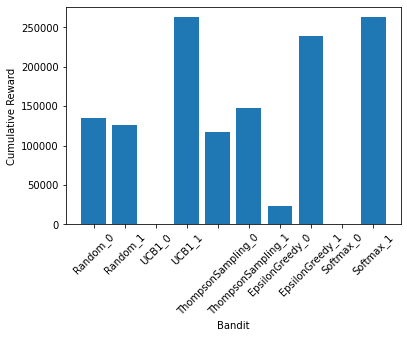

In [ ]:
####################################
# Context-Free Simulation
####################################
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=0, seed=123456)

# Como vamos a simular problemas sin contexto, los valores de context y scaler son None. test_size indica que un 50% de los datos se utilizarán como
# test. is_order indica que el train_test split es aleatorio. batch_size significa que en la etapa de testeo, cada resultado nuevo actualiza de
# manera online la política. Si se pusiera batch_size=50, se actualizaría la política cada 50 resultados.

sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    #Por cada mab se imprimen los resultados en el peor caso, caso promedio y mejor caso.
    print(mab_name)

    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name])

    print('\n\n')

sim.plot('avg', True)
# Vamos a plotear el escenario promedio para todos los bandidos utilizados. El parámetro True indica que en el plot se va a plotear por separado cada "brazo"

Estos gráficos plotean la ganancia acumulada por cada brazo de cada MAB. En este caso, como
las recompensas están definidas de antes, las suma de las recompensas de ambos brazos siempre será la misma, por lo que este ejemplo sirve para identificar la razón en la que se elige cada brazo según cada política.